In [1]:
from datasets import load_dataset
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from transformers import AutoTokenizer
from rlhfutils.data import preproc_wgpt, preproc_apf, preproc_hh
import matplotlib.pyplot as plt

/home/prasann/miniconda3/envs/stackenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
rlcd = load_dataset("csv", data_files="../rlcd-llama/simulated_data/simulated_preference_data_consolidated_helpful7b.csv")['train']

In [4]:
len(rlcd)

42662

In [5]:
webgpt = load_dataset("openai/webgpt_comparisons", split="train")
webgpt = pd.DataFrame([preproc_wgpt(w) for w in webgpt])

In [7]:
stack = load_dataset("lvwerra/stack-exchange-paired", data_dir="data/reward", split="train")
stack = stack.select(range(100000))
stack = pd.DataFrame(stack)

Resolving data files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129055.51it/s]

KeyboardInterrupt



In [6]:
apfgpt = load_dataset("tatsu-lab/alpaca_farm", 'alpaca_gpt4_preference')['preference']
apfhum= load_dataset("tatsu-lab/alpaca_farm", 'alpaca_human_preference')['preference']
apfgpt = pd.DataFrame([preproc_apf(w) for w in apfgpt])
apfhum = pd.DataFrame([preproc_apf(w) for w in apfhum])

Found cached dataset alpaca_farm (/u/prasanns/.cache/huggingface/datasets/tatsu-lab___alpaca_farm/alpaca_gpt4_preference/1.0.0/79d38dc3f12abd62869e376303b68092e8385769e22f05166fe96a3dac29a57a)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 396.03it/s]


/u/prasanns/.cache/huggingface/datasets/downloads/9c45dc9dfb8d6fc25d5bddb07f6b12f6024dbd153d61d0cfd6172cbeeac8f1b3


Dataset alpaca_farm downloaded and prepared to /u/prasanns/.cache/huggingface/datasets/tatsu-lab___alpaca_farm/alpaca_human_preference/1.0.0/79d38dc3f12abd62869e376303b68092e8385769e22f05166fe96a3dac29a57a. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.22it/s]


In [7]:
hh_train = load_dataset("Anthropic/hh-rlhf", data_dir="helpful-base", split="train")
hh_train = pd.DataFrame([preproc_hh(w) for w in hh_train])

Found cached dataset json (/u/prasanns/.cache/huggingface/datasets/Anthropic___json/Anthropic--hh-rlhf-37c6f75e35564d2a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


In [10]:
ind = 4
print(hh_train['response_k'][ind])
print("_____")
print(hh_train['response_j'][ind])

NameError: name 'hh_train' is not defined

In [11]:
tokenizer = AutoTokenizer.from_pretrained("../models/sft10k/")

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '../models/sft10k/'. Use `repo_type` argument if needed.

In [8]:
# NOTE I validated that RLCD doesn't have any input formatted stuff
def rlcdmakeprefs (inpdf):
    allres = []
    for row in inpdf:
        res = {}
        res['question'] = row['instruction']
        if row['preference']==1:
            res['response_j'] = row['output_1']
            res['response_k'] = row['output_2']
        else:
            res['response_j'] = row['output_2']
            res['response_k'] = row['output_1']
        allres.append(res)
    return pd.DataFrame(allres).dropna().reset_index(drop=True)

# take in processed df, given tokenizer, tokenize everything
def tokall (pdf): 
    gtoks = []
    btoks = []
    for ind, row in pdf.iterrows():
        gtoks.append(len(tokenizer(row['response_j']).input_ids))
        btoks.append(len(tokenizer(row['response_k']).input_ids))
    pdf['gtoks'] = gtoks
    pdf['btoks'] = btoks
    pdf['diffv'] = pdf['gtoks'] - pdf['btoks']
    return pdf

def lenbias (indf):
    return (indf['gtoks']>indf['btoks']).mean()

In [9]:
print("processing")
rlcproc = rlcdmakeprefs(rlcd)
print("tokenizing")
rlcproc = tokall(rlcproc)

processing
tokenizing


NameError: name 'tokenizer' is not defined

In [50]:
rlcproc['diffv'] = rlcproc['gtoks']-rlcproc['btoks']

(array([  176.,   412.,   814.,  2065., 14902., 17302.,  4247.,  1648.,
          819.,   275.]),
 array([-284. , -226.2, -168.4, -110.6,  -52.8,    5. ,   62.8,  120.6,
         178.4,  236.2,  294. ]),
 <BarContainer object of 10 artists>)

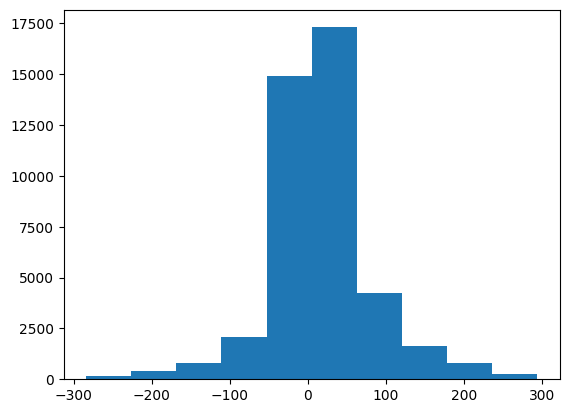

In [17]:
plt.hist(rlcproc['diff'])

In [16]:
wgptproc = tokall(webgpt)

In [18]:
mean(list(wgptproc.gtoks)+list(wgptproc.btoks))

179.59646031259578

In [44]:
def baldf(indf):
    df = indf.copy()
    # Create bins of 10
    bins = range(-200, 201, 10)
    df['bin'] = pd.cut(df['diffv'], bins=bins)
    
    # Initialize an empty DataFrame to store balanced data
    balanced_df = pd.DataFrame()
    
    # Get unique bin labels from the DataFrame
    unique_bins = df['bin'].dropna().unique()
    
    # Iterate through each pair of negative and positive bins
    for bin_label in unique_bins:
        if bin_label.left >= 0:
            continue
    
        # Find the positive counterpart of the current negative bin
        positive_bin = pd.Interval(-bin_label.right, -bin_label.left)
    
        # If the positive counterpart is not in unique_bins, skip this iteration
        if positive_bin not in unique_bins:
            continue
    
        # Find the counts for the negative and positive bins
        neg_count = df[df['bin'] == bin_label].shape[0]
        pos_count = df[df['bin'] == positive_bin].shape[0]
    
        # Find the minimum count to balance the data
        min_count = min(neg_count, pos_count)
    
        # Randomly sample min_count rows from each bin and append to balanced_df
        sampled_neg = df[df['bin'] == bin_label].sample(min_count, random_state=0)
        sampled_pos = df[df['bin'] == positive_bin].sample(min_count, random_state=0)
    
        balanced_df = pd.concat([balanced_df, sampled_neg, sampled_pos])
    
    # Reset index of the balanced DataFrame
    balanced_df.reset_index(drop=True, inplace=True)
    
    # Now balanced_df contains the balanced data
    return balanced_df

In [46]:
balwgpt = baldf(wgptproc)

In [51]:
balrlcd = baldf(rlcproc)

(array([  336.,   560.,   993.,  2212., 11306., 11306.,  2212.,   993.,
          560.,   336.]),
 array([-199. , -159.1, -119.2,  -79.3,  -39.4,    0.5,   40.4,   80.3,
         120.2,  160.1,  200. ]),
 <BarContainer object of 10 artists>)

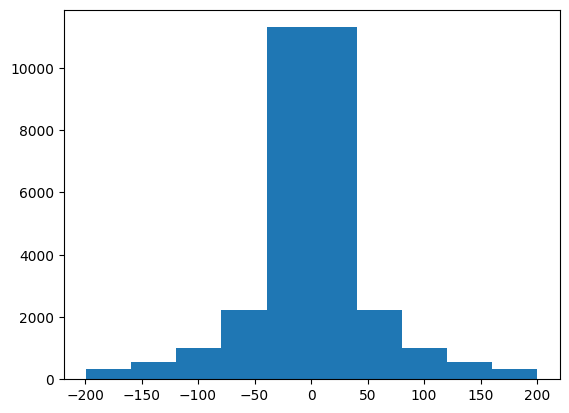

In [52]:
plt.hist(balrlcd.diffv)

In [45]:
lenbias(wgptproc)

0.5565430585350905

In [19]:
stackproc = tokall(stack)

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors


In [20]:
mean(list(stackproc.gtoks)+list(stackproc.btoks))

236.92451

In [52]:
lenbias(stackproc)

0.59698

In [10]:
apfhumbproc = tokall(apfhum)
apfgptproc = tokall(apfgpt)

In [11]:
print(lenbias(apfhumbproc))
print(lenbias(apfgptproc))

0.5418429470642865
0.535024650780608


In [29]:
hhproc = tokall(hh_train)

In [30]:
lenbias(hhproc)

0.5828219459336147